In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


             F1         F2         F3         F4         F5         F6  \
0   -140.885666  85.895836 -15.822802  -0.904439  -6.535247   1.688228   
1    -72.022278  81.035492 -15.902525  -2.386111 -15.858383  -6.126534   
2   -127.034081  68.531387  -9.903763  -5.387527 -11.311324  -5.520391   
3    -73.988068  74.953392 -13.380204  -1.377119  -7.199426   1.238755   
4    -73.136581  77.444756 -15.724725  -0.293866  -9.244156   1.907054   
..          ...        ...        ...        ...        ...        ...   
655  -63.742393  92.553810  -0.719851  20.213291   1.160641  11.932528   
656    0.800717  67.540604  20.871777   6.425647   9.779142  16.928787   
657  -16.192430  79.629387   9.371512  19.210546  10.595925  13.911086   
658  -36.092857  92.761734   7.287811   5.681164   8.787768  19.471151   
659   41.144283  63.999718  21.226656  10.455655   8.111396  15.395258   

            F7         F8         F9       F10        F11       F12       F13  \
0    -6.265729   0.647219 -11.

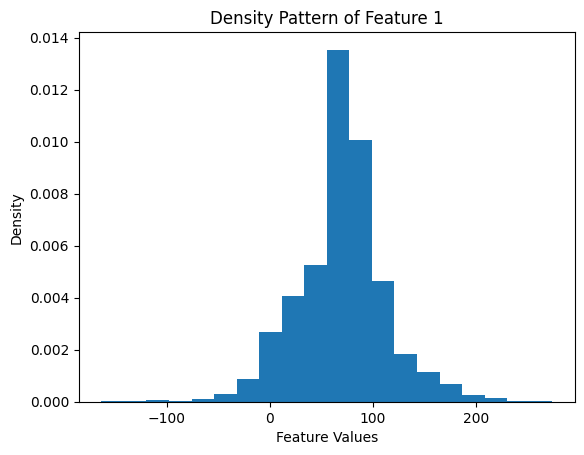

Mean of Feature 1: 80.50479706479726
Variance of Feature 1: 1839.697176479714


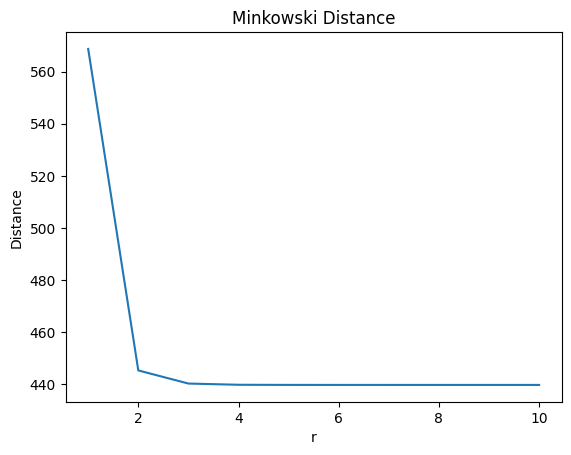

Accuracy: 0.9016666666666666
Predictions: [0. 0. 1. ... 0. 1. 1.]


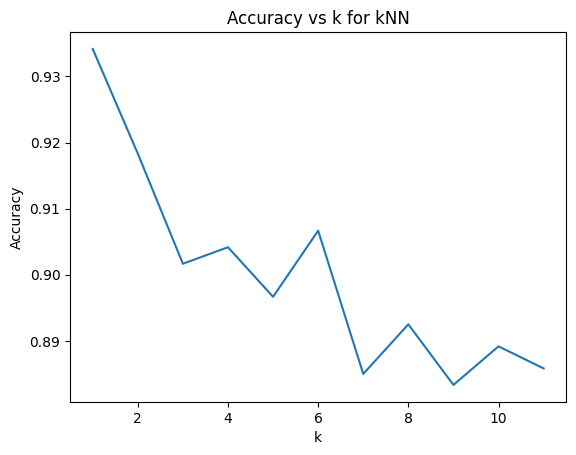

Confusion Matrix:
 [[472 112]
 [  6 610]]
Precision: 0.8448753462603878
Recall: 0.9902597402597403
F1 Score: 0.9118086696562033

               precision    recall  f1-score   support

         0.0       0.99      0.81      0.89       584
         1.0       0.84      0.99      0.91       616

    accuracy                           0.90      1200
   macro avg       0.92      0.90      0.90      1200
weighted avg       0.91      0.90      0.90      1200



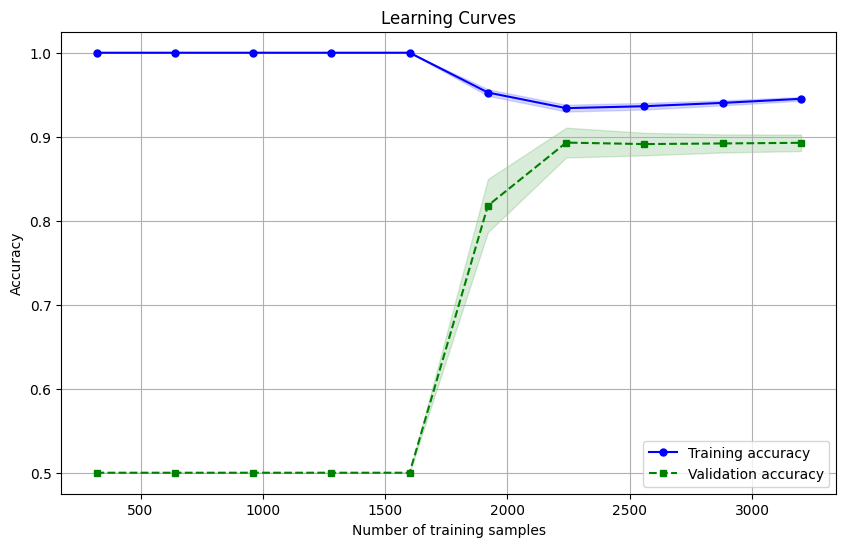

In [4]:
from glob import glob
import librosa
import pandas as pd
import numpy as np
from scipy.spatial.distance import minkowski
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pywt
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

def get_features(audios,labels):
  features_total=[]

  for i,x in enumerate(audios):  # Iterate over audio files and their corresponding labels
    y,sr=librosa.load(x)        # Load y-audio file and obtain the sampling rate (sr)
    D=librosa.stft(y)           # Compute Short-Time Fourier Transform (STFT) and convert to dB scale
    S_db=librosa.amplitude_to_db(np.abs(D),ref=np.max)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) # Extract Mel-frequency cepstral coefficients (MFCCs) #taking 13 features

    features=[]
    for f in mfccs:    # Calculate mean of each MFCC feature column
      feature=np.mean(f)
      features.append(feature)
    features.append(labels[i]) # Append the corresponding label to the feature vector
    features_total.append(features) # Append the feature vector to the list

  features_total=np.array(features_total) # Convert the list of feature vectors to a NumPy array

  features_total=pd.DataFrame(features_total,columns=["F1","F2","F3","F4","F5","F6","F7","F8","F9","F10","F11","F12","F13","Label"]) # Create a DataFrame with column names for features and label
  return features_total

POS ='/content/drive/MyDrive/aidataset/gunshot'
NEG = '/content/drive/MyDrive/aidataset/nongunshot'

pos = glob(POS + '/*.wav')
neg = glob(NEG + '/*.wav')

labels_1=[1]*len(pos) #list of files with label 1 - gunshot
labels_0=[0]*len(neg) #list of files with label 0 - non gunshot
fgun=get_features(pos,labels_1)
fnongun=get_features(neg,labels_0)

print(fgun)
print(fnongun)

# Repeat positive examples to match the number of negative examples
repeat_count = len(fnongun)// len(fgun)
remainder = len(fnongun) % len(fgun)

#nfgun = fgun
#for _ in range(repeat_count - 1):
    #nfgun = nfgun.concatenate(fgun)
nfgun = pd.concat([fgun] * repeat_count + [fgun.iloc[:remainder]]) #converting the files into a dataframe using pandas
data = pd.concat([fnongun, nfgun])
x = data.iloc[:, :-1] #feature vectors
y = data.iloc[:-1] #labels

#A1 Evaluate intraclass spread and interclass distances
def A1(fgun,fnongun):
  gun_mean = fgun.mean(axis=0)
  nongun_mean = fnongun.mean(axis=0)
  gun_std = fgun.std(axis=0)
  nongun_std = fnongun.std(axis=0)
  class_dist = np.linalg.norm(gun_mean - nongun_mean)
  return gun_mean,nongun_mean,gun_std,nongun_std,class_dist

gun_mean,nongun_mean,gun_std,nongun_std,class_dist=A1(nfgun,fnongun)
print("Gun Mean:\n", gun_mean)
print("Non-Gun Mean:\n", nongun_mean)
print("Gun Standard Deviation:\n", gun_std)
print("Non-Gun Standard Deviation:\n", nongun_std)
print("Interclass Distance:\n", class_dist)

#A2
def a2(data,index):
  feature_index = index
  feature_data = data.iloc[:, feature_index]

  # Calculate histogram
  hist, bins = np.histogram(feature_data, bins=20, density=True)

  # Plot histogram
  plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]))
  plt.title('Density Pattern of Feature {}'.format(feature_index))
  plt.xlabel('Feature Values')
  plt.ylabel('Density')
  plt.show()

  # Calculate mean and variance
  mean_value = feature_data.mean()
  variance_value = feature_data.var()
  return mean_value,variance_value

index=1
mean_value,variance_value=a2(data,index)
print("Mean of Feature {}: {}".format(index, mean_value))
print("Variance of Feature {}: {}".format(index, variance_value))

#A3
#feature vector 1 & 2
vector1 = fgun.iloc[0, :-1]
vector2 = fnongun.iloc[0, :-1]

r_values = range(1, 11)
#minkowski distance
distances = [minkowski(vector1, vector2, p) for p in r_values]

# Plot the distance
plt.plot(r_values, distances)
plt.xlabel('r')
plt.ylabel('Distance')
plt.title('Minkowski Distance')
plt.show()

#A4
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #splitting into training and testing data
#A5 , A6 , A7
#Train kNN classifier (k = 3)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
#Test accuracy of kNN
accuracy = neigh.score(X_test, y_test) #k is increasing, accuracy is decreasing
print("Accuracy:", accuracy)
#Use predict() function to study prediction behavior
ypredict = neigh.predict(X_test)
print("Predictions:", ypredict)

#A8 Compare kNN with NN classifier (k = 1 to 11)
accuracies = []
for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    accuracies.append(accuracy)
plt.plot(range(1, 12), accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k for kNN')
plt.show()

#A9 Evaluate confusion matrix and other performance metrics like precision, recall, F1 score
conf_matrix = confusion_matrix(y_test, ypredict)
precision = precision_score(y_test, ypredict)
recall = recall_score(y_test, ypredict)
f1 = f1_score(y_test, ypredict)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

report = classification_report(y_test, ypredict)
print("\n",report)

# Define the kNN classifier
neigh = KNeighborsClassifier(n_neighbors=3)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(neigh, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Compute mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

# Add labels, title, and legend
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()